<a href="https://colab.research.google.com/github/neuroqudit/pyngn/blob/main/notebooks/05_benchmark_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. Benchmark: MNIST Classification

This notebook benchmarks the **Triglial Reservoir** (3GSNN) on the MNIST digit classification task.
We use a Liquid State Machine (LSM) approach:
1.  **Encoder**: Convert image pixels to spike trains (Poisson coding).
2.  **Reservoir**: TriglialReservoir (Neurons + Astrocytes + Microglia + Delays) processes the spatiotemporal patterns.
3.  **Readout**: Ridge Regression trains on the reservoir states to predict the digit class.

In [ ]:
!pip install pyngn

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

from pyngn.reservoir import TriglialReservoir

%matplotlib inline

## 1. Load Data
We use a subset of MNIST for speed in this demo.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download MNIST
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Use subset for quick benchmark (e.g., 500 samples)
subset_size = 500
train_subset = Subset(train_data, range(subset_size))
test_subset = Subset(test_data, range(100))

train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.06MB/s]


## 2. Poisson Encoder
Convert pixel intensity (0-1) to spike probability.

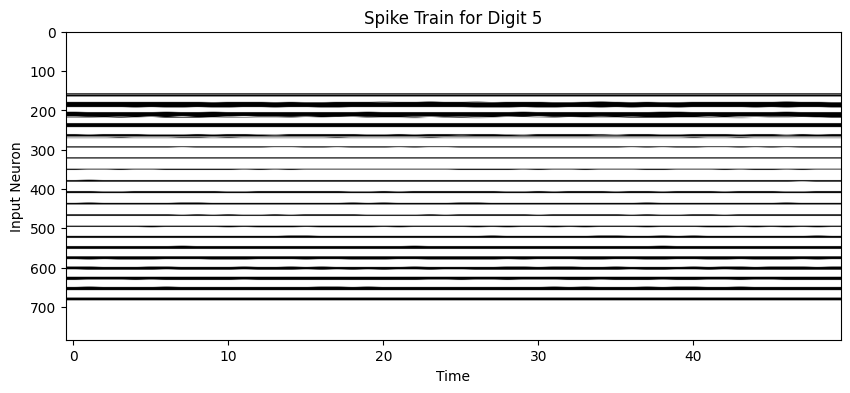

In [4]:
def poisson_encode(image, time_steps=50, gain=10.0):
    # image: [1, 28, 28]
    # Flatten: [784]
    pixels = image.view(-1)

    # Rate proportional to intensity
    rate = pixels * gain # Hz (approx)

    # Generate spikes: [time_steps, 784]
    # Prob of spike per step (dt=1ms) = rate * dt/1000
    # Let's assume rate is prob per step for simplicity
    prob = torch.clamp(rate * 0.1, 0, 1) # Scaling factor

    spikes = torch.rand(time_steps, pixels.shape[0]) < prob.unsqueeze(0)
    return spikes.float()

# Visualize one sample
img, label = train_subset[0]
spikes = poisson_encode(img)
plt.figure(figsize=(10, 4))
plt.imshow(spikes.T, aspect='auto', cmap='Greys')
plt.title(f"Spike Train for Digit {label}")
plt.xlabel("Time")
plt.ylabel("Input Neuron")
plt.show()

## 3. Initialize Reservoir

In [5]:
input_dim = 784
hidden_dim = 100 # Small reservoir for demo
output_dim = 10  # Digits 0-9

model = TriglialReservoir(input_dim, hidden_dim, output_dim,
                          dt=1.0, max_delay=10,
                          astro_params={'target_rate': 0.1},
                          micro_params={'pruning_threshold': 0.3})

print("Reservoir Initialized")

Reservoir Initialized


## 4. Training (Readout)
We run the reservoir on training data, collect states, and train the readout.

In [6]:
X_train_states = []
Y_train_targets = []

print("Collecting reservoir states...")
for i, (img, label) in enumerate(train_loader):
    # Encode
    spikes = poisson_encode(img)

    # Run Reservoir
    # Collect state for batch training
    prediction, state = model(spikes, return_state=True)

    X_train_states.append(state.squeeze(0)) # [hidden_dim]

    # One-hot target
    target = torch.zeros(10)
    target[label] = 1.0
    Y_train_targets.append(target)

    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} samples")

# Stack
X_train = torch.stack(X_train_states) # [n_samples, hidden_dim]
Y_train = torch.stack(Y_train_targets) # [n_samples, output_dim]

print(f"Training Readout on {X_train.shape[0]} samples...")
model.readout.fit(X_train, Y_train)
print("Training Complete.")

Processed 100 samples
Processed 200 samples
Processed 300 samples
Processed 400 samples
Processed 500 samples
Training Readout on 500 samples...
Training Complete.


## 5. Evaluation
Test on unseen data.

In [7]:
correct = 0
total = 0

print("Evaluating...")
with torch.no_grad():
    for img, label in test_loader:
        spikes = poisson_encode(img)

        # Run Reservoir (no training)
        prediction = model(spikes)

        predicted_class = torch.argmax(prediction).item()
        true_class = label.item()

        if predicted_class == true_class:
            correct += 1
        total += 1

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Evaluating...
Test Accuracy: 71.00%
